<a href="https://colab.research.google.com/github/torrhen/pytorch/blob/main/02_multi_class_classifcation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import third party function using requests HTTP library
import requests
from pathlib import Path # file management library

if Path('helper_functions.py').is_file(): # true if a valid file exists
  # no need to download, already exists
  pass
else:
  # download file using HTTP
  # send a GET resquest to a webpage
  response = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')

  # write to a binary file f (wb) or create the file if it does not yet exist
  with open('helper_functions.py', 'wb') as f:
    f.write(response.content) # write the content of the webpage to f
  # close file once finished

In [ ]:
from sklearn.datasets import make_blobs

# create multi-class dataset
X, y = make_blobs(n_samples=1000, centers=4, cluster_std=1.5, random_state=42)

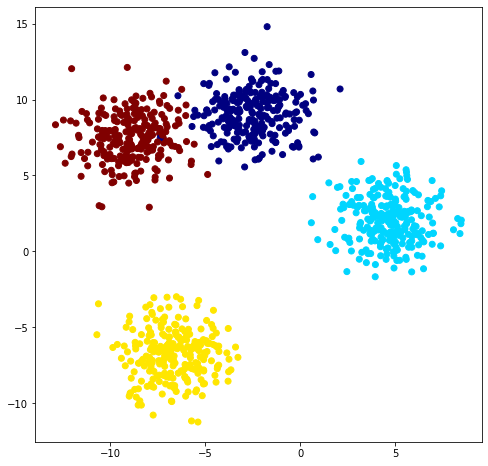

In [ ]:
import matplotlib.pyplot as plt

# plot full dataset
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.jet)
plt.show()

In [ ]:
import torch

# convert numpy arrays to tensors
X = torch.from_numpy(X).type(torch.float32) # size [1000, 2]
y = torch.from_numpy(y).type(torch.long) # size [1000,]

In [ ]:
from sklearn.model_selection import train_test_split

# split data
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [ ]:
from torch import nn

# build model
class MultiClassModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer1 = nn.Linear(in_features=2, out_features=5)
    self.layer2 = nn.Linear(in_features=5, out_features=5)
    self.layer3 = nn.Linear(in_features=5, out_features=4)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))


In [ ]:
# instantiate model and allocate to device
model = MultiClassModel().to(device)
print(model.state_dict())

OrderedDict([('layer1.weight', tensor([[ 0.3094, -0.4900],
        [-0.3337,  0.1795],
        [ 0.4510, -0.2467],
        [ 0.1999,  0.6126],
        [ 0.4141,  0.5392]])), ('layer1.bias', tensor([ 0.1140,  0.0059,  0.5509, -0.6712, -0.5411])), ('layer2.weight', tensor([[-0.3602,  0.1786, -0.1751, -0.1056, -0.3701],
        [-0.3972,  0.1064,  0.0365,  0.4131,  0.2051],
        [-0.3017,  0.1708,  0.0020,  0.0012, -0.3903],
        [ 0.1333, -0.1287, -0.1725, -0.0657, -0.1000],
        [ 0.4024, -0.4193, -0.0923, -0.0161,  0.2362]])), ('layer2.bias', tensor([ 0.0045, -0.3402,  0.2433,  0.3479,  0.0883])), ('layer3.weight', tensor([[-0.1737, -0.1987, -0.2412, -0.2707,  0.3755],
        [-0.0771,  0.2632,  0.4276,  0.1531, -0.3765],
        [-0.3630, -0.3387,  0.4005, -0.2232, -0.0239],
        [-0.0931, -0.3336,  0.4032,  0.3614,  0.1184]])), ('layer3.bias', tensor([-0.0707, -0.3761,  0.1141,  0.0469]))])


In [ ]:
# allocate data to device
train_X = train_X.to(device)
test_X = test_X.to(device)
train_y = train_y.to(device)
test_y = test_y.to(device)

In [ ]:
# set up loss function
loss_func = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [ ]:
# import mertics from torchmetrics
!pip install torchmetrics
from torchmetrics import Accuracy

accuracy = Accuracy().to(device)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# training and test loop
epochs = 1000

for epoch in range(epochs):
  model.train() # set to training mode

  # forward pass
  pred_y_logits = model(train_X)
  pred_y_labels = torch.argmax(torch.softmax(pred_y_logits, dim=1), dim=1)

  # calculate loss
  loss = loss_func(pred_y_logits, train_y)
  acc = accuracy(pred_y_labels, train_y).to(device) * 100

  # prevent accumulated gradients
  optimizer.zero_grad()

  # backprop
  loss.backward()

  # gradient descent
  optimizer.step()

  model.eval() # set to evaluation model
  with torch.inference_mode(): # stop tracking gradients of parameters while testing
    pred_y_logits_test = model(test_X)
    pred_y_labels_test = torch.argmax(torch.softmax(pred_y_logits_test, dim=1), dim=1)

    test_loss = loss_func(pred_y_logits_test, test_y)
    test_acc = accuracy(pred_y_labels_test, test_y).to(device) * 100

    if epoch % 10 == 0:
      print(f"epoch: {epoch} | loss: {loss:.5f} | acc: {acc:.2f}% | test_loss: {test_loss:.5f} | test acc: {test_acc:.2f}%")




epoch: 0 | loss: 1.50093 | acc: 5.00% | test_loss: 1.45504 | test acc: 7.00%
epoch: 10 | loss: 1.41316 | acc: 15.00% | test_loss: 1.37437 | test acc: 17.50%
epoch: 20 | loss: 1.34292 | acc: 21.62% | test_loss: 1.31077 | test acc: 26.50%
epoch: 30 | loss: 1.27980 | acc: 28.75% | test_loss: 1.25414 | test acc: 33.00%
epoch: 40 | loss: 1.21963 | acc: 37.50% | test_loss: 1.20028 | test acc: 38.00%
epoch: 50 | loss: 1.16812 | acc: 44.88% | test_loss: 1.15342 | test acc: 45.50%
epoch: 60 | loss: 1.12386 | acc: 51.50% | test_loss: 1.11126 | test acc: 51.50%
epoch: 70 | loss: 1.08238 | acc: 53.25% | test_loss: 1.07119 | test acc: 55.00%
epoch: 80 | loss: 1.04351 | acc: 55.12% | test_loss: 1.03298 | test acc: 56.50%
epoch: 90 | loss: 1.00718 | acc: 56.63% | test_loss: 0.99702 | test acc: 58.50%
epoch: 100 | loss: 0.97313 | acc: 57.88% | test_loss: 0.96308 | test acc: 58.00%
epoch: 110 | loss: 0.94183 | acc: 58.00% | test_loss: 0.93138 | test acc: 59.50%
epoch: 120 | loss: 0.91321 | acc: 57.38% 

In [ ]:
# make predictions
model.eval()
with torch.inference_mode():
  y_pred = model(test_X)
  y_pred_labels = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)


In [ ]:
from helper_functions import plot_decision_boundary

# 1 row, 2 column subplots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1) # select the index of the first subplot
plt.title('training set')
plot_decision_boundary(model, train_X, train_y) # plot boundary
plt.subplot(1, 2, 2) # select the index of the second subplot
plt.title('test set')
plot_decision_boundary(model, test_X, test_y) # plot boundary
plt.show()